In [1]:
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from polygraphs.analysis import Processor

In [2]:
class BeliefProcessor(Processor):
    def __init__(self, path):
        super().__init__(path)
        # Add the columns when processor is initialized
        self.add(self.mean(0.5, 0.75, 0.9, 0.99), self.quantile(0.5, 0.75, 0.9, 0.99, quantiles=(0.25,)))

    def mean(self, *thresholds):
        """Calculate when mean beliefs first met a threshold and count crossings."""
        def get_mean_with_recrossings(iterations, threshold=0.5):
            mean_iteration = iterations.groupby("iteration").mean()
            above_threshold = mean_iteration["beliefs"] > threshold
            crossings = ((above_threshold & ~above_threshold.shift(fill_value=False)) |
                         (~above_threshold & above_threshold.shift(fill_value=False))).sum()
            first_crossing = mean_iteration[above_threshold].index[0] if above_threshold.any() else None
            return first_crossing, crossings
        
        for threshold in thresholds:
            threshold = float(threshold)
            if 0 <= threshold <= 1:
                first_crossing_list = []
                crossing_count_list = []
                for belief in self.beliefs:
                    first_crossing, crossing_count = get_mean_with_recrossings(belief, threshold)
                    first_crossing_list.append(first_crossing)
                    crossing_count_list.append(crossing_count)
                column = f"mean_{str(threshold).replace('.', '_')}"
                crossing_column = column + "_crossings"
                self.dataframe[column] = first_crossing_list
                self.dataframe[crossing_column] = crossing_count_list

    def quantile(self, *thresholds, quantiles=(0.25,)):
        """Calculate when quantile beliefs first met a threshold and count crossings."""
        def get_quantile(iterations, threshold, quantile_level):
            quantile_iteration = iterations.groupby("iteration").quantile(quantile_level)
            above_threshold = quantile_iteration['beliefs'] > threshold
            count_crossings = ((above_threshold & ~above_threshold.shift(fill_value=False)) |
                               (~above_threshold & above_threshold.shift(fill_value=False))).sum()
            iterations_above_threshold = quantile_iteration[quantile_iteration['beliefs'] > threshold]
            return iterations_above_threshold.index[0] if len(iterations_above_threshold) > 0 else None, count_crossings

        for threshold in thresholds:
            threshold = float(threshold)
            if 0 <= threshold <= 1:
                for quantile_level in quantiles:
                    if 0 <= quantile_level <= 1:
                        quantile_list = []
                        crossings_list = []
                        for belief in self.beliefs:
                            first_crossing, crossing_count = get_quantile(belief, threshold, quantile_level)
                            quantile_list.append(first_crossing)
                            crossings_list.append(crossing_count)
                        column = f"quantile_{str(threshold).replace('.', '_')}_q{int(quantile_level * 100)}"
                        crossing_column = column + "_crossings"
                        self.dataframe[column] = quantile_list
                        self.dataframe[crossing_column] = crossings_list

    def aggregate_crossings_by_op(self):
        """Aggregate threshold crossings by operator."""
        aggregated = self.dataframe.copy()
        numeric_data = aggregated.select_dtypes(include=["number"])
        numeric_data["op"] = aggregated["op"]
        return numeric_data.groupby("op").sum()

In [3]:
# Initialize processor
processor = BeliefProcessor("~/polygraphs-cache/results/")
# x.get()

In [4]:
# Function to compute centrality based on metric type
def compute_centrality(graph, metric):
    if not graph.is_directed():
        graph = nx.DiGraph(graph)
    if metric == "in_degree":
        return nx.in_degree_centrality(graph)
    elif metric == "out_degree":
        return nx.out_degree_centrality(graph)
    elif metric == "eigenvector":
        return nx.eigenvector_centrality(graph, max_iter=1000, tol=1e-06)
    else:
        raise ValueError(f"Unsupported centrality metric: {metric}")

# Desired percentiles
percentiles = [0, 25, 50, 75, 90, 99, 100]  # Min, 25th, 50th, 75th, 90th, 99th, Max

## (a) By Simulation

In [ ]:
def plot_beliefs_by_centrality_sim(sim_id, metric, processor):
    beliefs = processor.beliefs[sim_id].reset_index()
    graph = processor.graphs[sim_id]
    
    # Compute centrality
    centrality = compute_centrality(graph, metric)
    beliefs[f"{metric}_centrality"] = beliefs["node"].map(centrality)
    
    # Get centrality values and map percentiles
    centrality_values = beliefs[f"{metric}_centrality"].dropna()
    thresh = [centrality_values.quantile(p / 100) if p < 100 else centrality_values.max() for p in percentiles]
    labels = ["Min", "25th", "50th", "75th", "90th", "99th", "Max"]
    beliefs[f"{metric}_percentile"] = pd.cut(beliefs[f"{metric}_centrality"], bins=[-float('inf')] + thresh[:-1] + [float('inf')], labels=labels, include_lowest=True)
    
    # Filter to one representative node per percentile (e.g., closest to the threshold)
    rep_nodes = {}
    for p, t in zip(labels, thresh):
        if p == "Max":
            node = beliefs.loc[beliefs[f"{metric}_centrality"].idxmax(), "node"]
        else:
            node = beliefs.iloc[(beliefs[f"{metric}_centrality"] - t).abs().argsort()[0]]["node"]
        rep_nodes[p] = node
    
    # Plot beliefs over iterations for these nodes
    plt.figure(figsize=(14, 7))
    for label, node in rep_nodes.items():
        node_data = beliefs[beliefs["node"] == node]
        sns.lineplot(data=node_data, x="iteration", y="beliefs", label=label, marker="o")
    
    plt.title(f"Beliefs by {metric.capitalize()} Centrality Percentile (Sim {sim_id})", fontsize=16)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Credence", fontsize=12)
    plt.legend(title="Centrality Percentile")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"images/beliefs_by_{metric}_centrality_sim_{sim_id}.png", dpi=300, bbox_inches="tight")
    plt.show()

## (b) Across Simulations, Averaging by Operator

In [ ]:
def plot_beliefs_by_centrality_agg(processor, metric):
    agg_data = []
    for sim_id, sim_row in processor.sims.iterrows():
        beliefs = processor.beliefs[sim_id].reset_index()
        graph = processor.graphs[sim_id]
        op = sim_row.op
        
        # Compute centrality
        centrality = compute_centrality(graph, metric)
        beliefs[f"{metric}_centrality"] = beliefs["node"].map(centrality)
        
        # Get centrality percentiles
        centrality_values = beliefs[f"{metric}_centrality"].dropna()
        thresh = [centrality_values.quantile(p / 100) if p < 100 else centrality_values.max() for p in percentiles]
        labels = ["Min", "25th", "50th", "75th", "90th", "99th", "Max"]
        beliefs[f"{metric}_percentile"] = pd.cut(beliefs[f"{metric}_centrality"], bins=[-float('inf')] + thresh[:-1] + [float('inf')], labels=labels, include_lowest=True)
        
        # Select representative nodes
        rep_nodes = {}
        for p, t in zip(labels, thresh):
            if p == "Max":
                node = beliefs.loc[beliefs[f"{metric}_centrality"].idxmax(), "node"]
            else:
                node = beliefs.iloc[(beliefs[f"{metric}_centrality"] - t).abs().argsort()[0]]["node"]
            rep_nodes[p] = node
        
        # Add operator and filter
        node_data = beliefs[beliefs["node"].isin(rep_nodes.values())].copy()
        node_data["op"] = op
        node_data["percentile"] = node_data["node"].map({v: k for k, v in rep_nodes.items()})
        agg_data.append(node_data[["op", "iteration", "beliefs", "percentile"]])
    
    # Combine and average by operator
    agg_df = pd.concat(agg_data)
    agg_by_op = agg_df.groupby(["op", "percentile", "iteration"])["beliefs"].mean().reset_index()
    
    # Plot for each operator
    for op in agg_by_op["op"].unique():
        op_data = agg_by_op[agg_by_op["op"] == op]
        plt.figure(figsize=(14, 7))
        for percentile in op_data["percentile"].unique():
            perc_data = op_data[op_data["percentile"] == percentile]
            sns.lineplot(data=perc_data, x="iteration", y="beliefs", label=percentile, marker="o")
        
        plt.title(f"Aggregated Beliefs by {metric.capitalize()} Centrality Percentile (Op: {op})", fontsize=16)
        plt.xlabel("Iteration", fontsize=12)
        plt.ylabel("Credence", fontsize=12)
        plt.legend(title="Centrality Percentile")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"images/agg_beliefs_by_{metric}_centrality_op_{op}.png", dpi=300, bbox_inches="tight")
        plt.show()

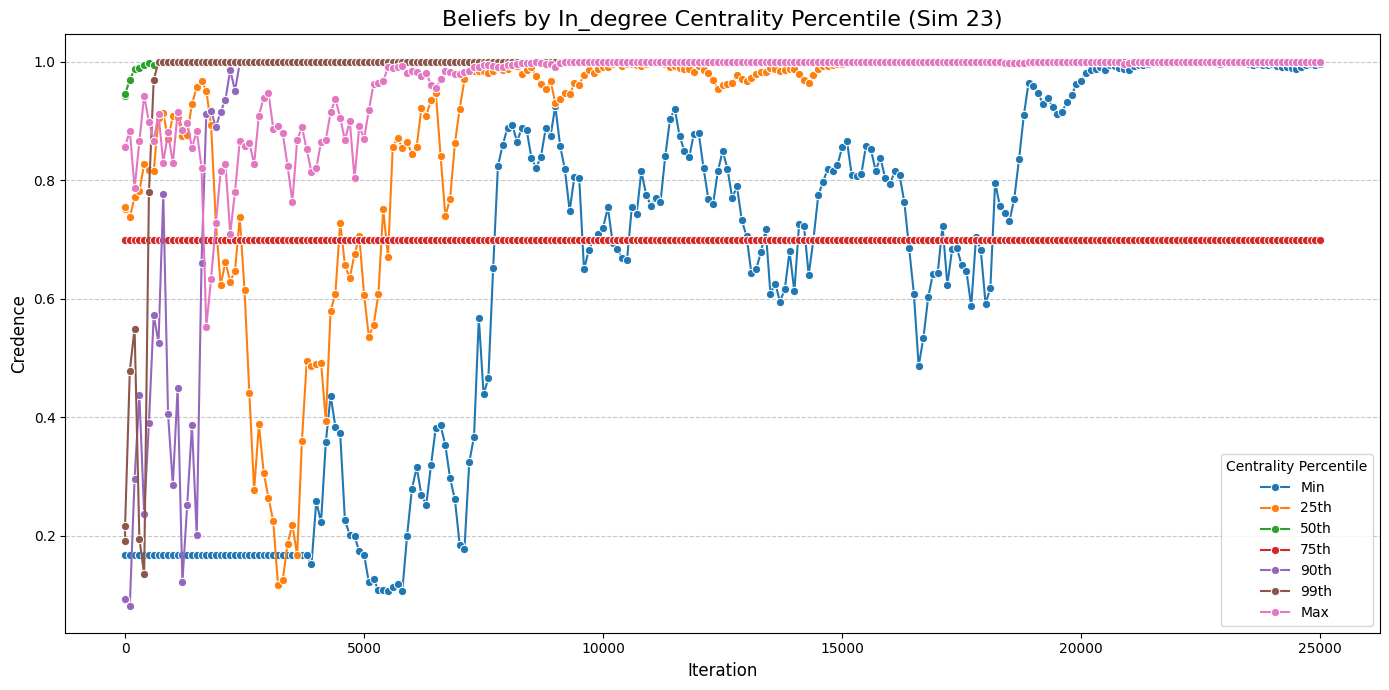

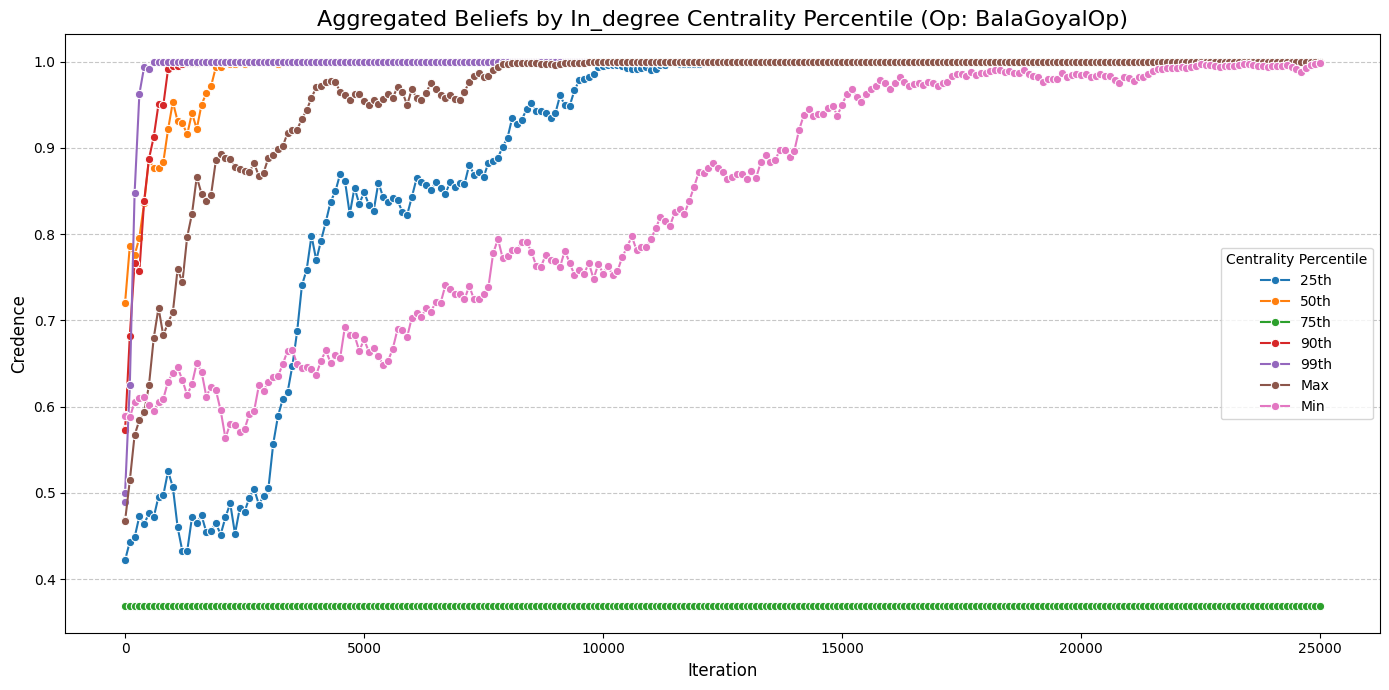

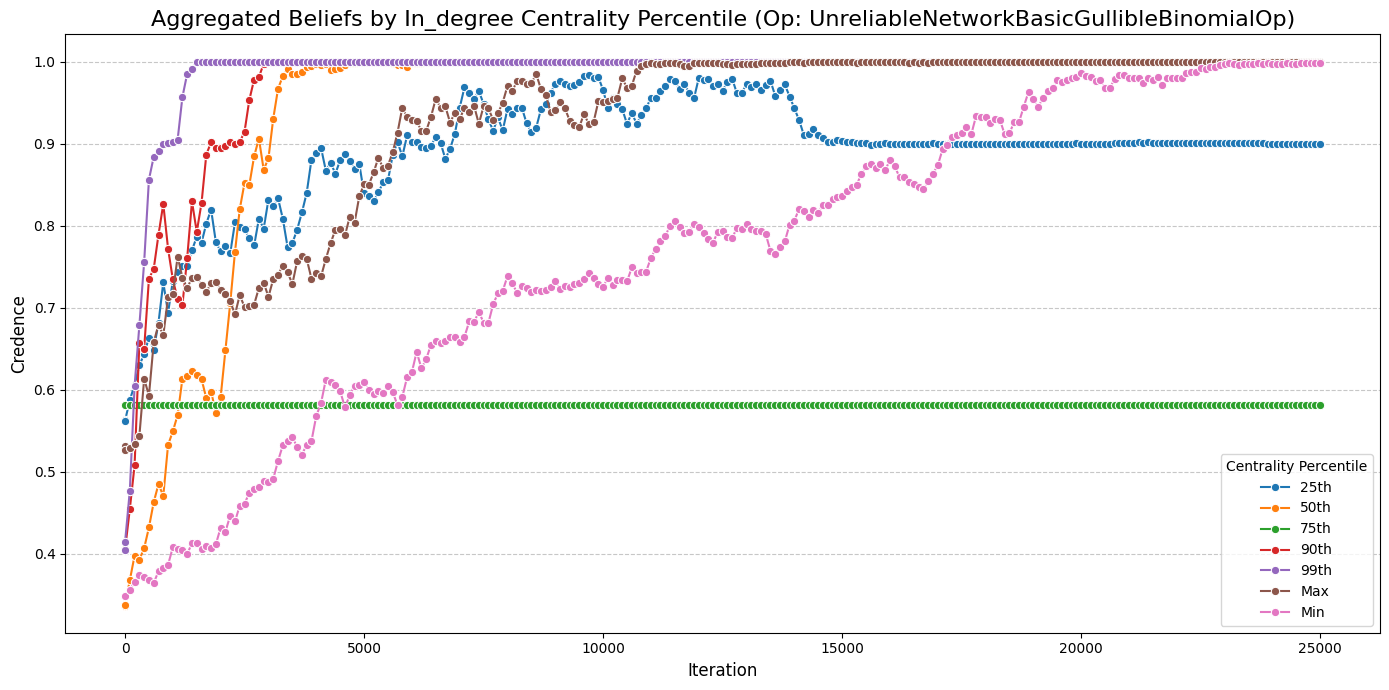

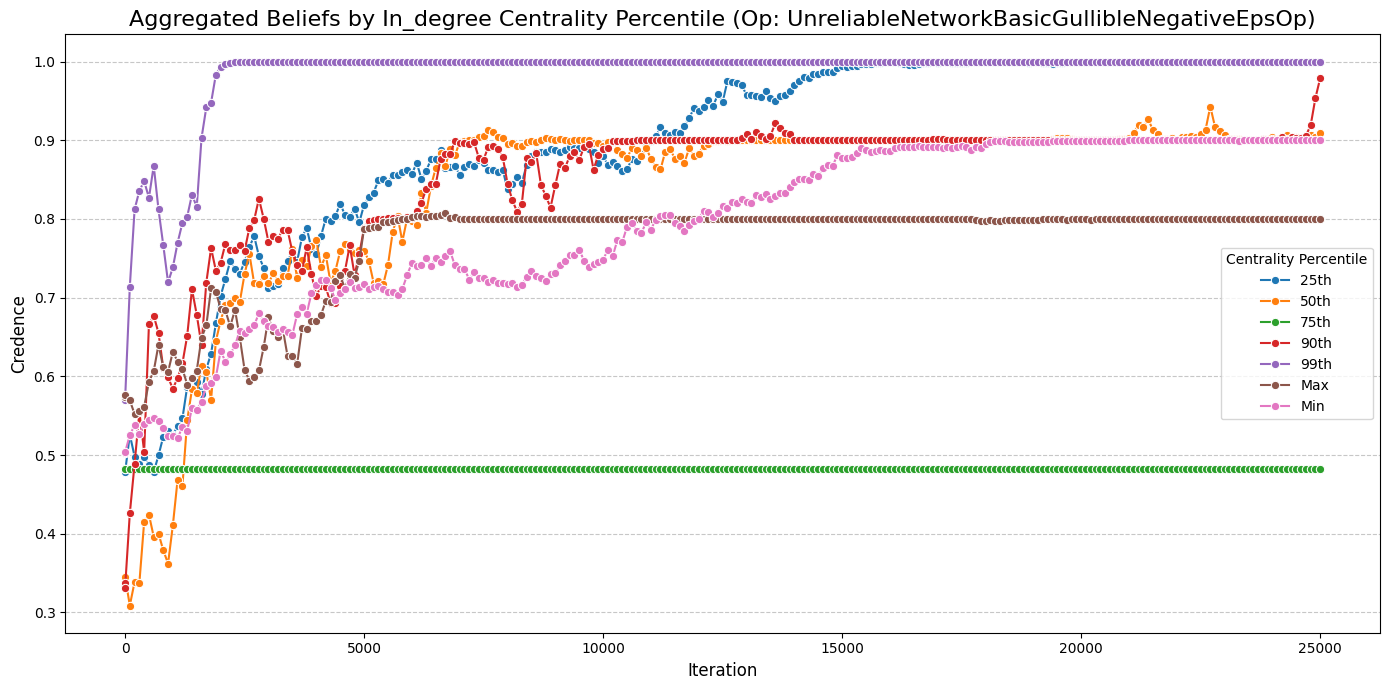

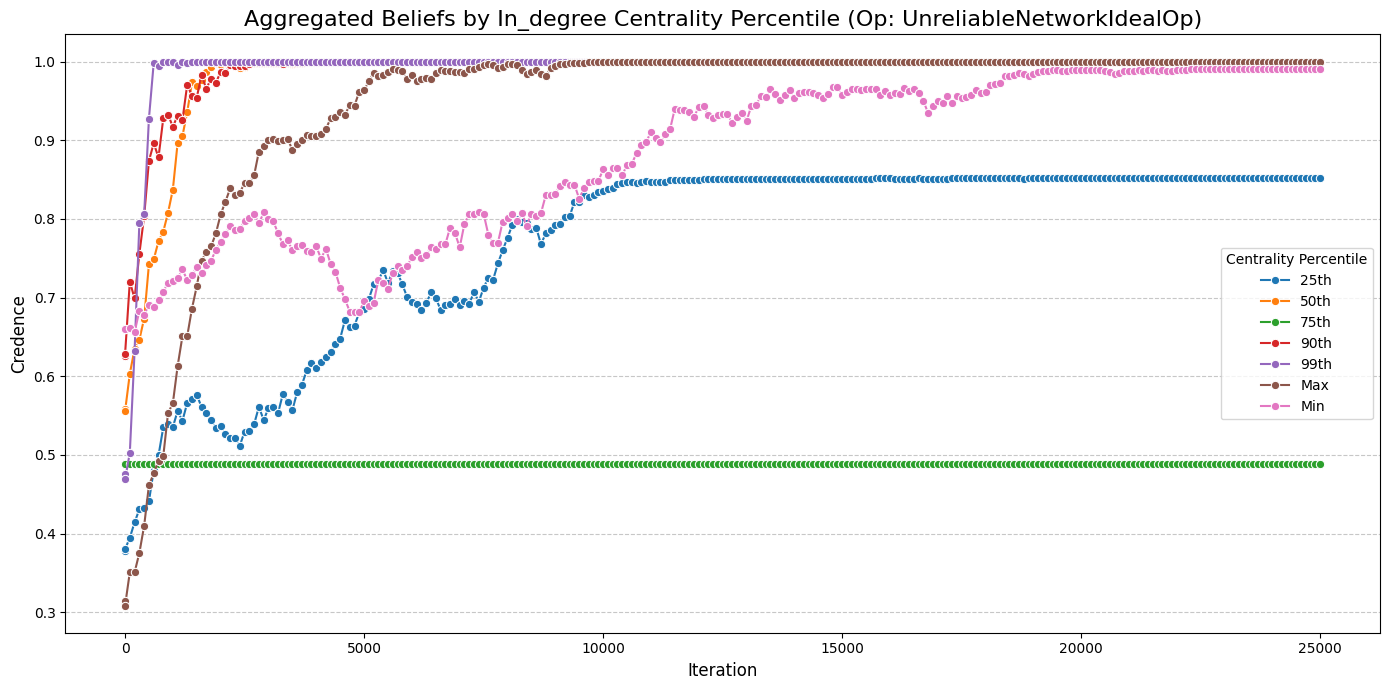

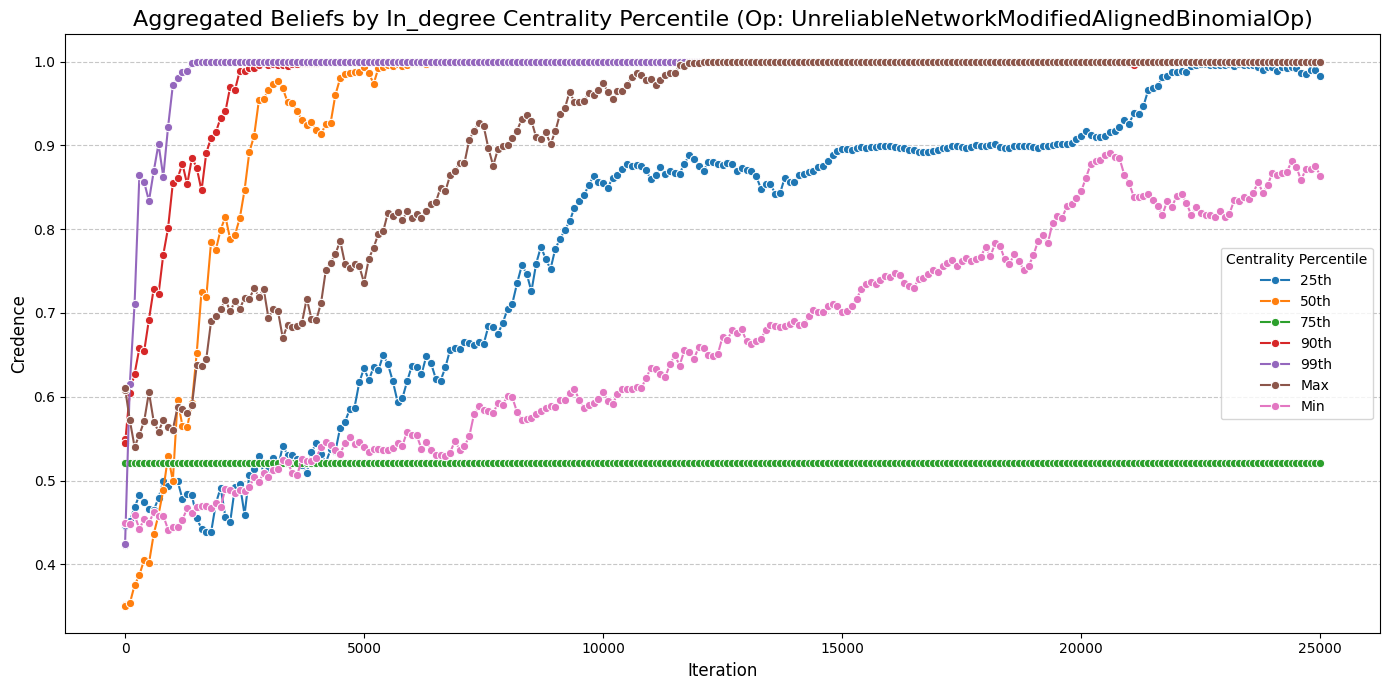

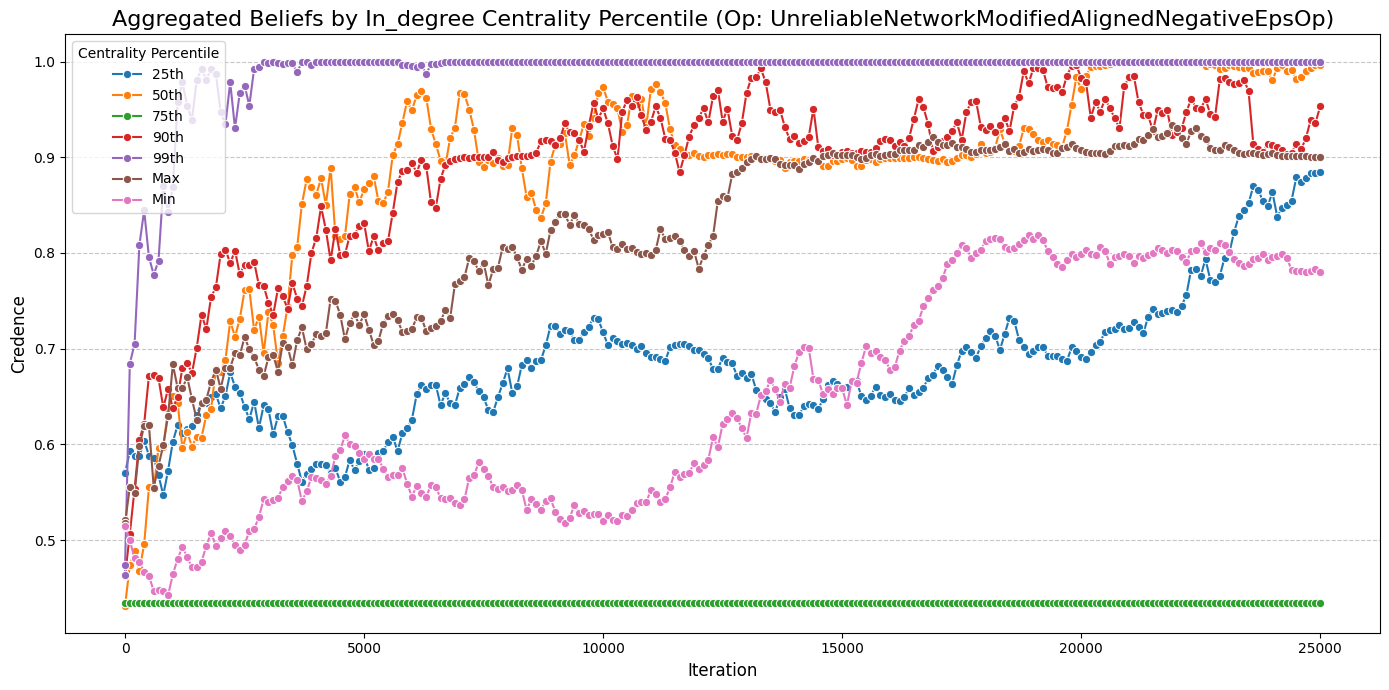

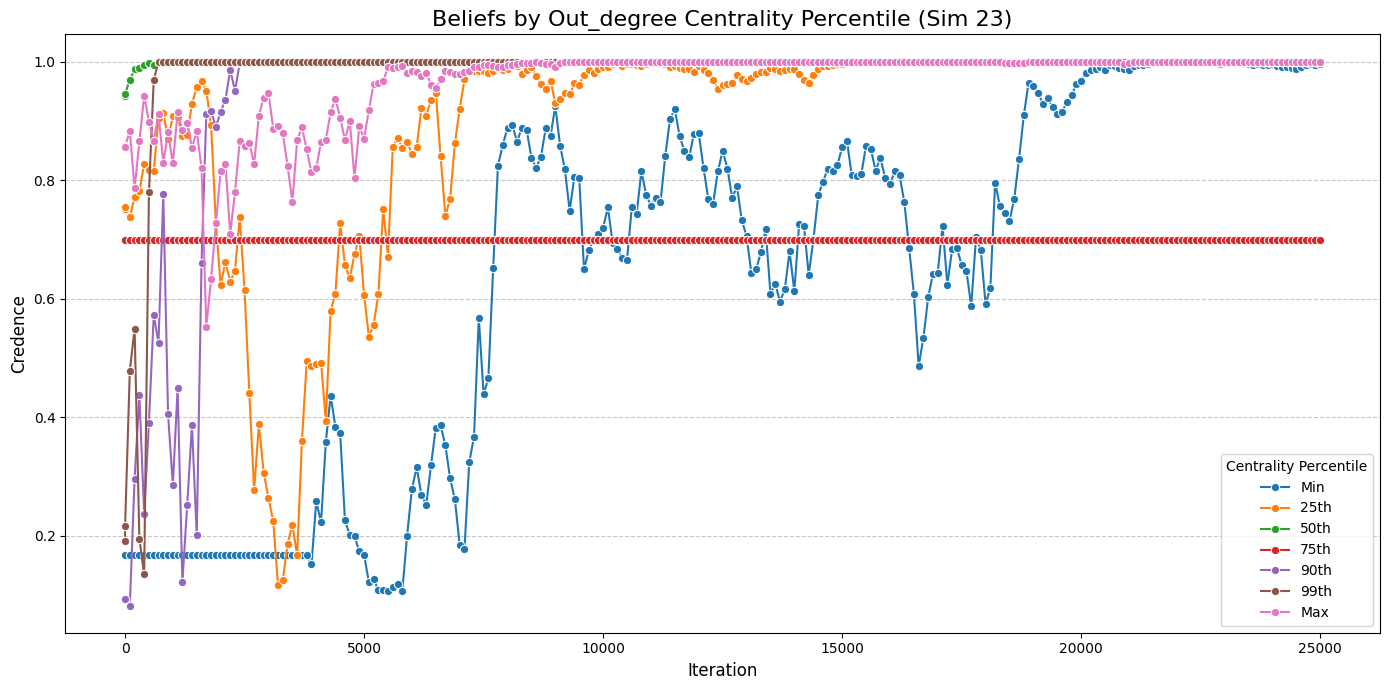

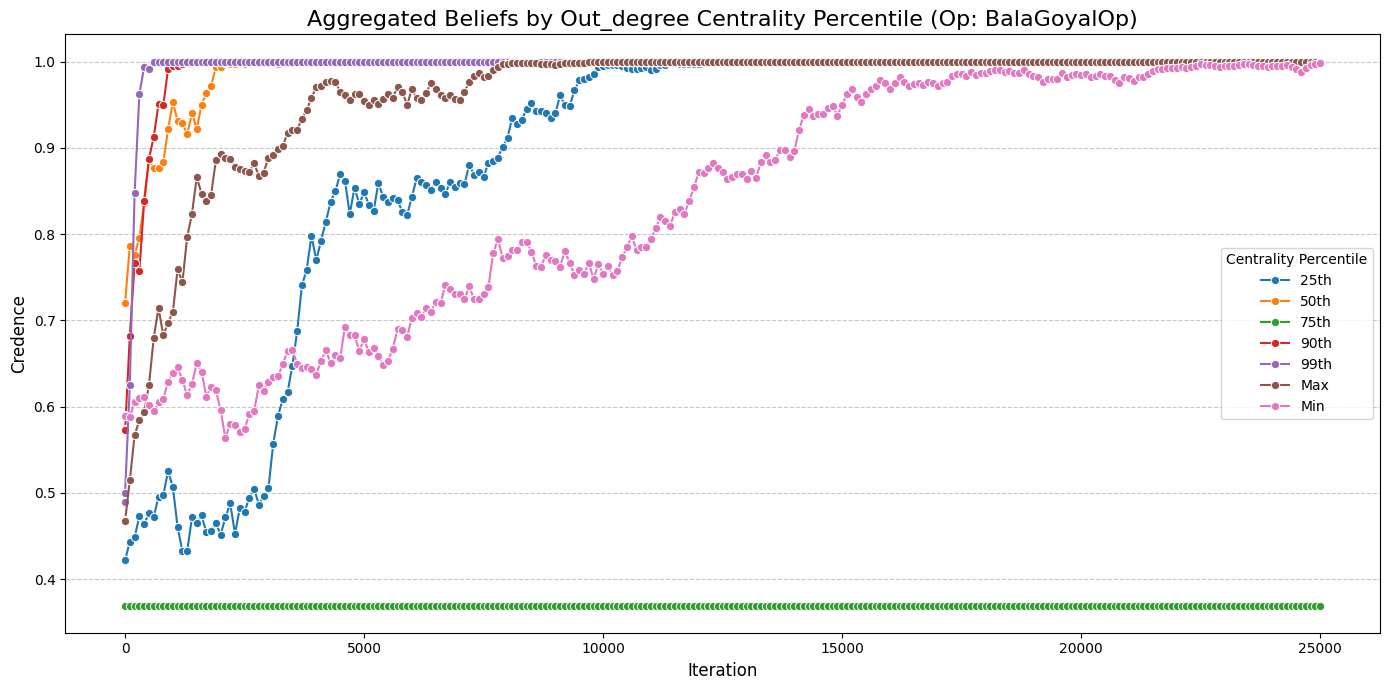

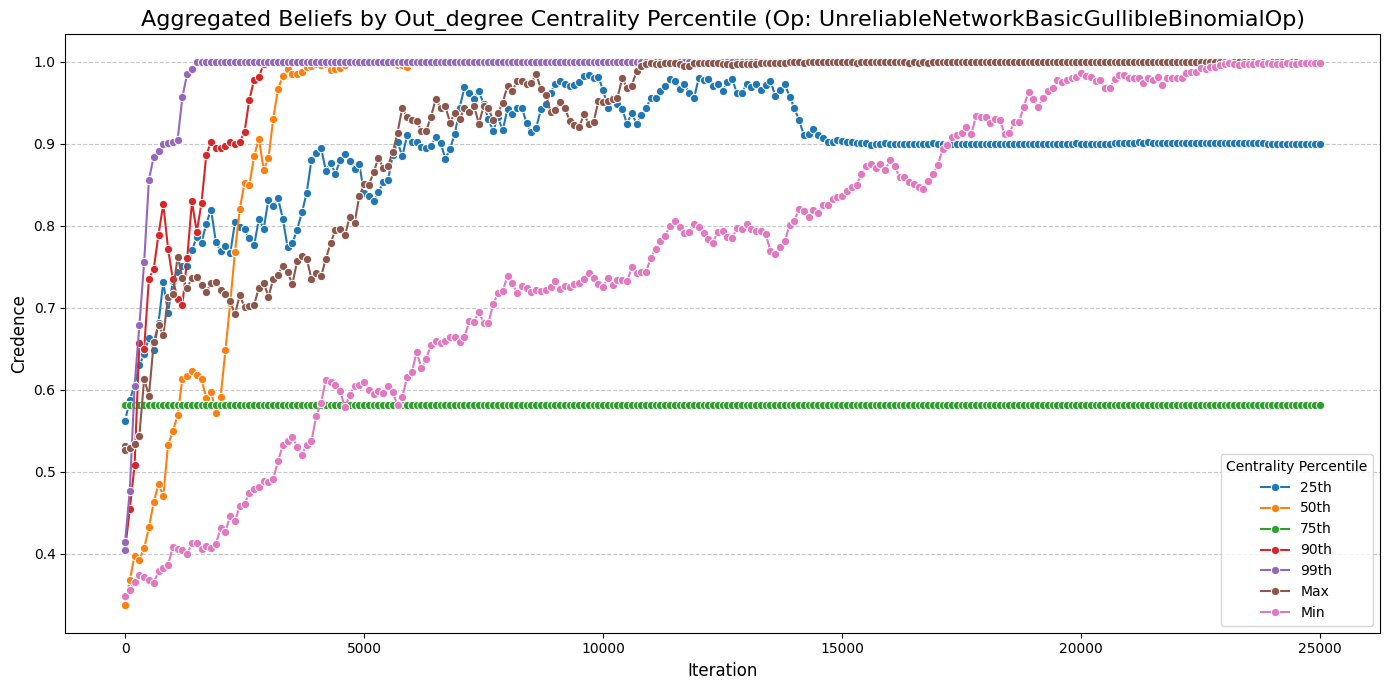

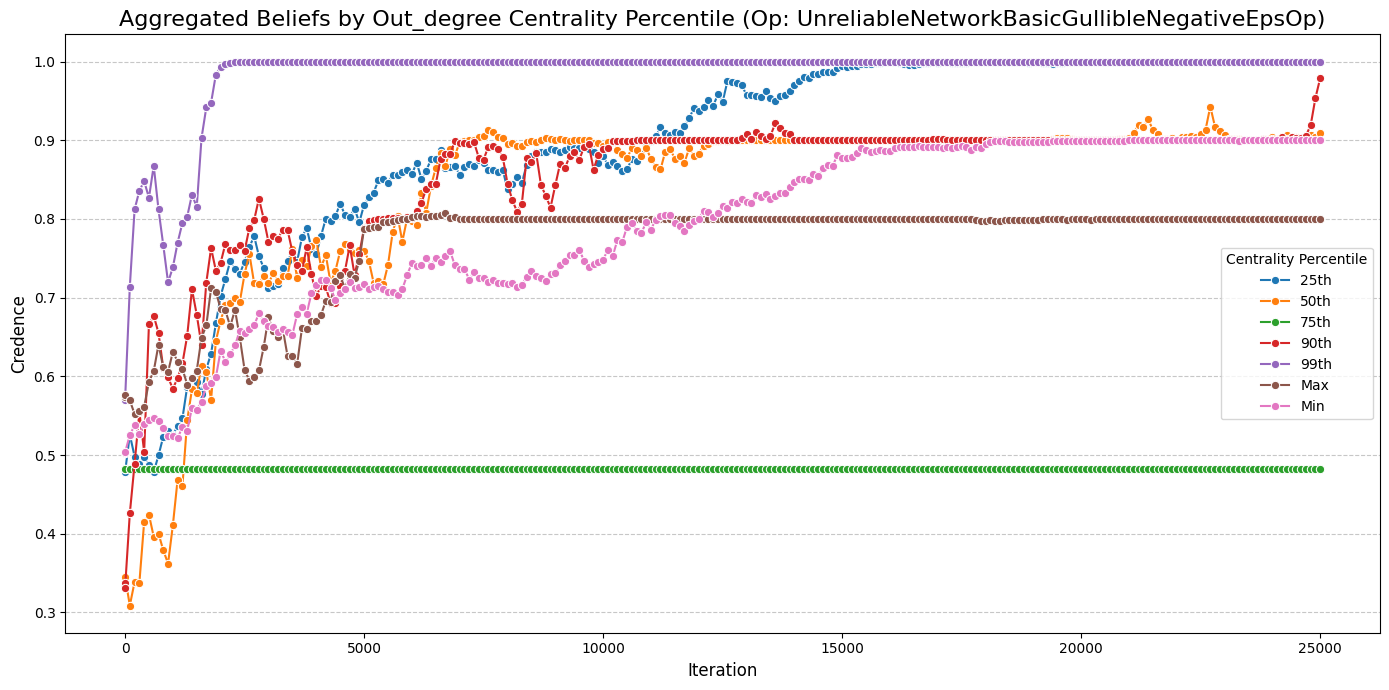

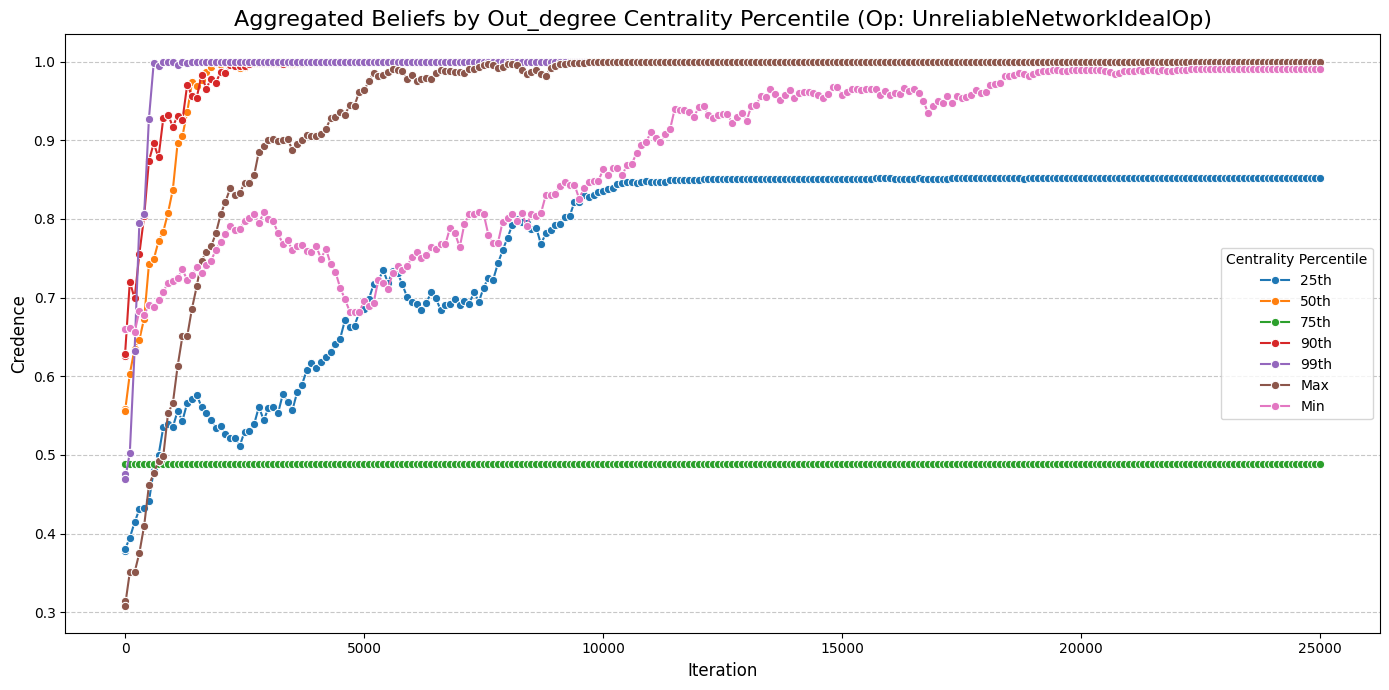

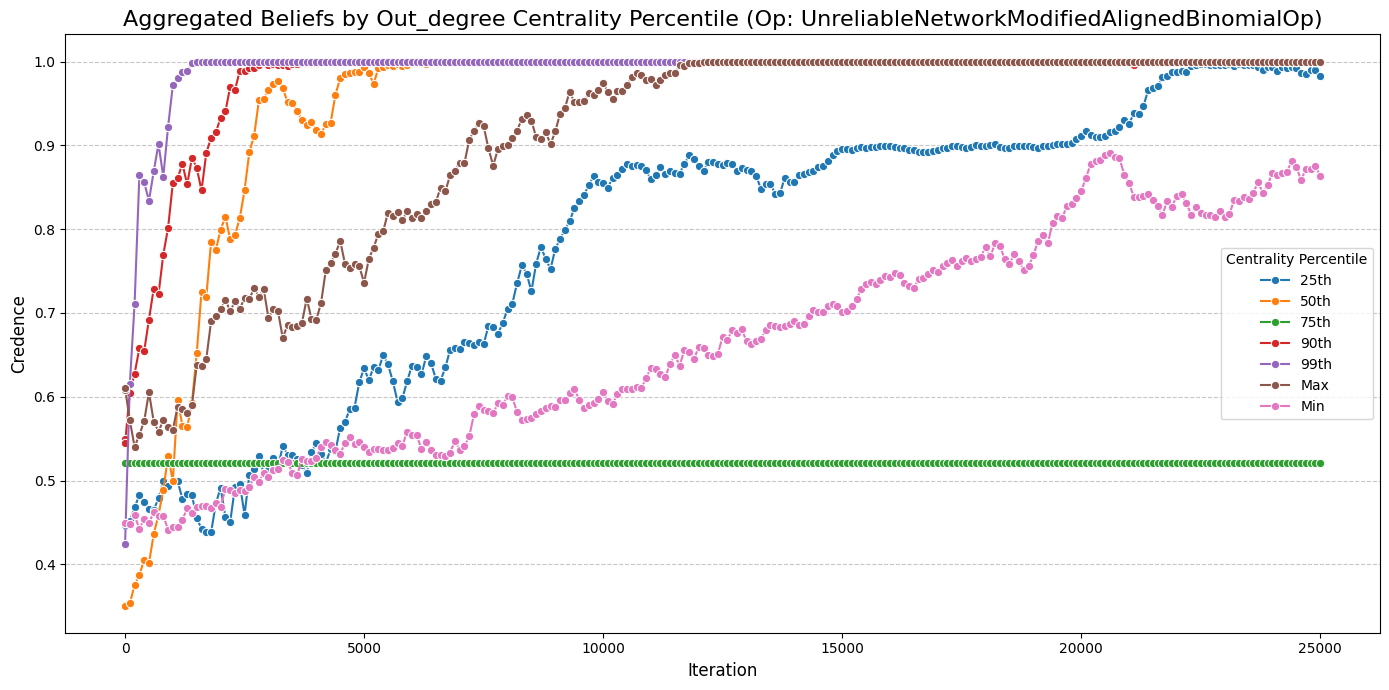

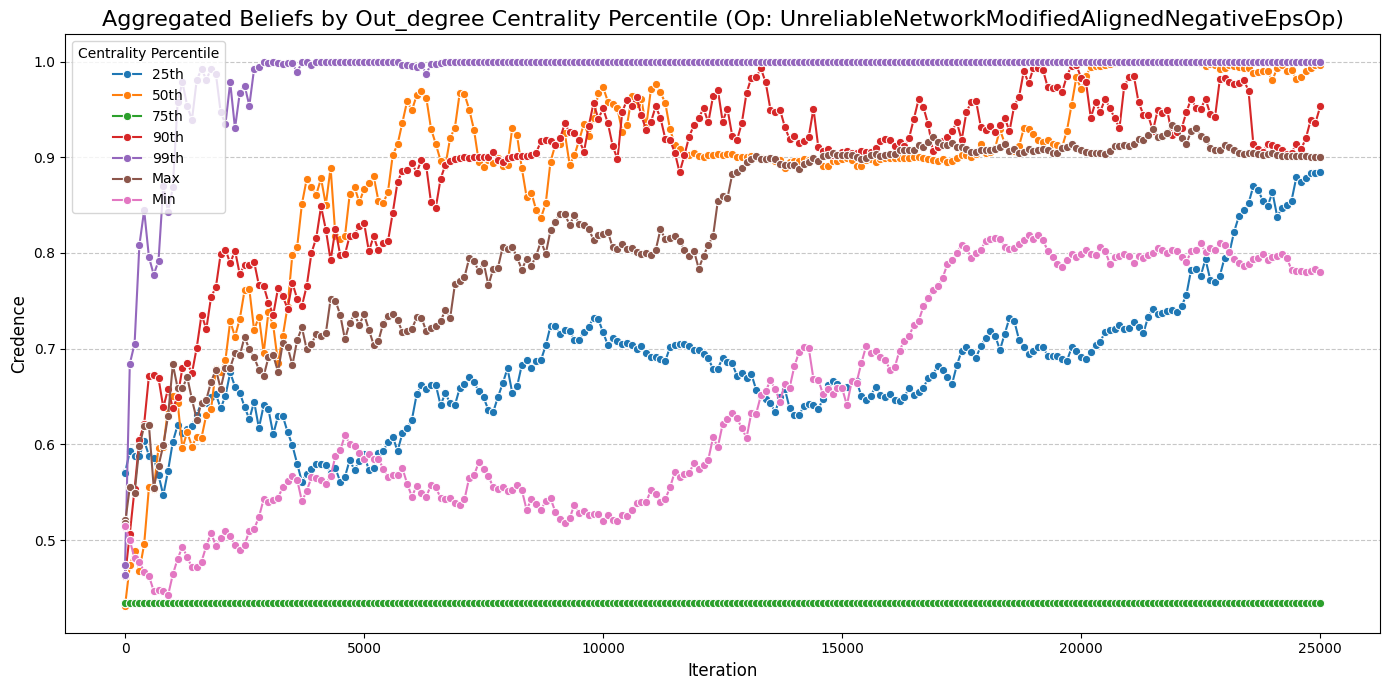

In [ ]:
# Example usage for a simulation
sim_id = 23  
for metric in ["in_degree", "out_degree"]:
    plot_beliefs_by_centrality_sim(sim_id, metric, processor)
    plot_beliefs_by_centrality_agg(processor, metric)